In [1]:
import pathlib, sys

sys.path.insert(0, str(pathlib.Path().resolve().parent))

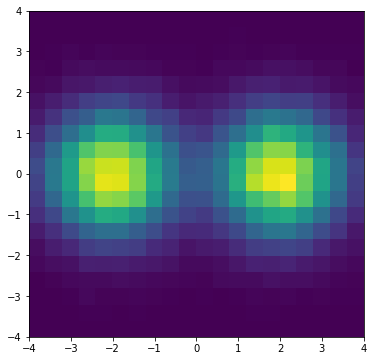

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(1234)

# bimodal Gaussian
toy_data = np.concatenate([
    np.random.normal(loc=(-2,0),size=(50000, 2)),
    np.random.normal(loc=(2,0),size=(50000, 2))
], axis=0)


plt.figure(figsize=(6, 6))
_ = plt.hist2d(
    toy_data[:,0], toy_data[:,1], 
    range=[[-4,4],[-4,4]],
    bins=(20, 20),
    density=True
)

In [6]:
from tqdm import tqdm
import torch
from flows import NormalizingFlow
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader, Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = 2

flow = NormalizingFlow(input_dim, ["planar", "radial"]*3)
flow.to(device)

n_epochs = 10

optimizer = SGD(flow.parameters(), lr=0.001, momentum=0.8, weight_decay=0, nesterov=True)
# optimizer = Adam(planar_flow.parameters(), lr=0.01, weight_decay=5e-3)


class ToyDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __getitem__(self, idx):
        return self.data[idx]
    def __len__(self):
        return len(self.data)

ds = ToyDataset(toy_data)
train_loader = DataLoader(ds, batch_size=5000)
    
for e in range(n_epochs):
    with tqdm(train_loader, desc=f"{e+1}/{n_epochs} epochs") as t:
        train_neg_logp = 0
        train_total = 0
        for i, x in enumerate(t):
            neg_logp = flow(x.flatten(start_dim=1).to(device))
            optimizer.zero_grad()
            neg_logp.backward()
            optimizer.step()
            flow.modify()
            train_neg_logp += neg_logp.item()*x.size(0)
            train_total += x.size(0)
            t.set_postfix({"train_neg_logp": train_neg_logp/train_total})

10/10 epochs: 100%|███████████████████████████████████████████████| 20/20 [00:00<00:00, 26.81it/s, train_neg_logp=3.48]


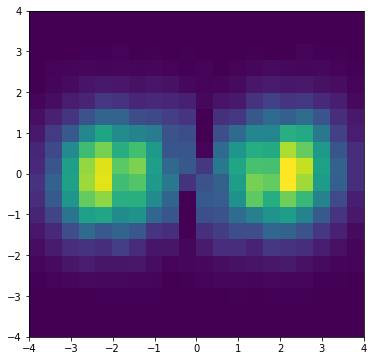

In [7]:
torch.manual_seed(1234)
z = torch.randn((100000, 2))
x = flow.inverse(z)

plt.figure(figsize=(6, 6))
_ = plt.hist2d(
    x[:,0], x[:,1], 
    range=[[-4,4],[-4,4]],
    bins=(20, 20),
    density=True
)